In [15]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'dlvis2020-entregables/assignment1_colab/cs231n/'
FOLDERNAME = 'dlvis2020-entregables/assignment1_colab/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-10-18 15:14:53--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  15.9MB/s    in 11s     

2020-10-18 15:15:05 (14.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://iie.fing.edu.uy/~jlezama/DLVIS2020/entregables.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [16]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [18]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time
%reload_ext autoreload

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.397708
sanity check: 2.302585


**Inline Question 1**

- 1.1 Why do we expect our loss to be close to -log(0.1)? Explain briefly.
- 1.2 What are the minimum and maximum possible value for the Softmax loss? 

$\color{blue}{\textit Your Answer:}$ 

- 1.1 Dado que se cuenta con 10 clases, la probabilidad que la clasificación sea de una determinada clase es 0.1. La función de entropía cruzada es el promedio de -log(probabilidad ejemplo sea de clase objetivo). Por lo que se espera que en un conjunto importante de ejemplos, la entropía cruzada se aproxime a -log(0.1)

- 1.2 si la probabilidad calculada por softmax para cada ejemplo fuera 1 para para la clase objetivo del ejemplo (probabilidad ideal a alcanzar), la entropía cruzada valdría -log(1)=0. 
Por el contrario, si para todos los ejemplos la probabilidad calculada por softmax fuera 0 para la clase objetivo del ejemplo, entonces la entropía cruzada valdría -log(0). Dicho valor no existe pero al aproximarse a cero tinde a infinito.



In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.815699 analytic: -1.815699, relative error: 3.931774e-08
numerical: -0.150983 analytic: -0.150983, relative error: 1.027425e-07
numerical: 1.789852 analytic: 1.789852, relative error: 5.088352e-09
numerical: -0.390115 analytic: -0.390115, relative error: 4.330402e-08
numerical: -3.318749 analytic: -3.318749, relative error: 9.103284e-09
numerical: -1.697004 analytic: -1.697004, relative error: 2.519338e-08
numerical: 0.883139 analytic: 0.883139, relative error: 6.723554e-08
numerical: 0.211946 analytic: 0.211946, relative error: 1.009199e-08
numerical: -0.640016 analytic: -0.640016, relative error: 8.386218e-08
numerical: -0.581901 analytic: -0.581901, relative error: 6.142262e-08
numerical: 2.570007 analytic: 2.570007, relative error: 1.556551e-08
numerical: 0.001246 analytic: 0.001246, relative error: 3.074566e-05
numerical: 0.504610 analytic: 0.504609, relative error: 2.122397e-07
numerical: -1.943112 analytic: -1.943112, relative error: 1.317034e-08
numerical: -3.6167

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# W e use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.397708e+00 computed in 0.166404s
vectorized loss: 2.397708e+00 computed in 0.013198s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [22]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 767.293195
iteration 100 / 1500: loss 281.673702
iteration 200 / 1500: loss 104.417729
iteration 300 / 1500: loss 39.561488
iteration 400 / 1500: loss 15.797611
iteration 500 / 1500: loss 7.158671
iteration 600 / 1500: loss 3.962647
iteration 700 / 1500: loss 2.739818
iteration 800 / 1500: loss 2.317414
iteration 900 / 1500: loss 2.200133
iteration 1000 / 1500: loss 2.119450
iteration 1100 / 1500: loss 2.105190
iteration 1200 / 1500: loss 2.094114
iteration 1300 / 1500: loss 2.053705
iteration 1400 / 1500: loss 2.085243
That took 7.476996s


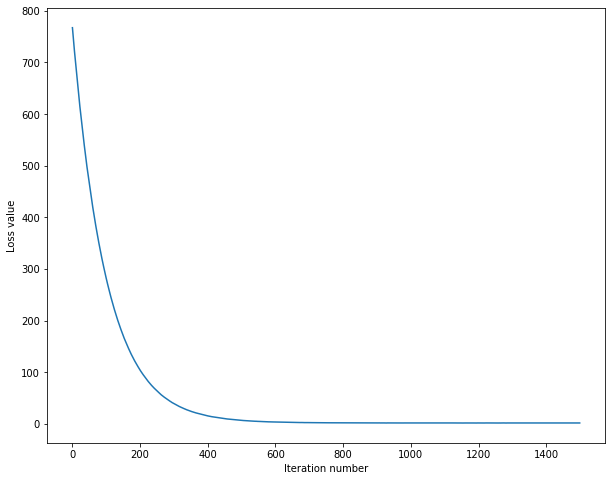

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [24]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329286
validation accuracy: 0.338000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save  the best trained softmax classifer in best_softmax.                    #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.0e4, 4e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

modelo = Softmax()

for i in learning_rates:
    for j in regularization_strengths:
        loss_hist = modelo.train(X_train, y_train, i, j, num_iters=1500)

        prediccionesTrain = modelo.predict(X_train)
        prediccionesValidacion = modelo.predict(X_val)

        accurancy_train = np.mean(y_train == prediccionesTrain)
        accurancy_validation = np.mean(y_val == prediccionesValidacion)
        
        results[(i, j)] = (accurancy_train, accurancy_validation)
        
        if accurancy_validation > best_val:
            best_val = accurancy_validation
            best_softmax = modelo

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.350408 val accuracy: 0.370000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.333571 val accuracy: 0.353000
lr 1.000000e-06 reg 2.000000e+04 train accuracy: 0.344878 val accuracy: 0.353000
lr 1.000000e-06 reg 4.000000e+04 train accuracy: 0.332102 val accuracy: 0.343000
best validation accuracy achieved during cross-validation: 0.370000


In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution: 
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?
- How would it affect the training process? You may test this experimentally.


$\color{blue}{\textit Your Answer:}$
- El uso del parámetro T se utiliza para suavizar las probabilidades estimadas por el modelo. A mayores valores de T, las probabilidades de cada clase para un ejemplo tenderán a ser parecidas, teniendo menos confianza en las predicciones. A mayores valores de T, se penaliza más a las probabilidades mayores, sobre las menores, debido a que exp es una función creciente. 
Si T es 1, las probabilidades calculadas serán las originales (sin tener en cuenta T), y será el caso en el que el modelo es más confiable. 

- En el entrenamiento, a mayor valor de T (con T=10), la pérdida se acerca a -log(0.1). Esto quiere decir que a todas las clases le está asignando probabilidades cercanas a 0.1 (todas las clases con la misma probabilidad). En particular un clasificador así no sirve porque no tiene confianza al momento de predecir una clase para un ejemplo. Con T más bajo, se pueden suavizar las probabilidades, para llegar a un compromiso entre aleatoriedad y confianza.  





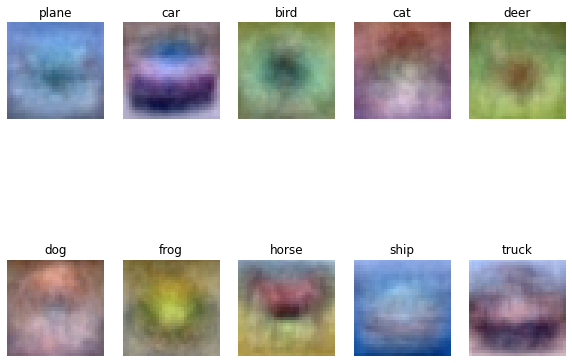

In [27]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [28]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))